**Data Processing**

In [ ]:
# 挂载到谷歌云端硬盘
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 安装OpenCV库
!pip install opencv-python
import cv2 # 导入OpenCV，用于图像处理与计算机视觉操作

# 导入系统和文件操作相关库
import os, sys, random, shutil
from shutil import copyfile # 用于复制文件
# 可以按照通配符*模式，可批量查找文件路径
from glob import glob

# 解析XML标注文件，用于目标检测任务
import xml.etree.ElementTree as ET

# 数据预处理模块，用于标签编码、数据标准化等
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import LabelEncoder # 标签编码器，可将类别文字转为数字
from sklearn.model_selection import train_test_split # 用于划分训练集和测试集

# 用于数据处理与分析，如表格形式DataFrame
import pandas as pd
# 用于数值计算和数组处理
import numpy as np
# 用于数据可视化
import matplotlib.pyplot as plt
from matplotlib import patches #可以绘制矩形、圆形等图形，用于标注框的可视化
# Jupyter Notebook命令，用于显示图像
%matplotlib inline

In [ ]:
df = [] # 用来存放所有解析出的标注信息，每张图片可能有多个目标
cnt = 0 # 用来给图片重命名，如0.tif, 1.tif, 2.tif...

# 首先参考XML文件来理解它的结构
# 找到指定路径下的所有XML文件，并排序以保证顺序一致
annotations = sorted(glob("/content/drive/MyDrive/tobacco_data/Description_XML/*.xml"))

# 遍历每一个XML文件
for file in annotations:
    # 解析XML文件，获取根节点
    myroot = ET.parse(file).getroot()

    # 图像文件名更改为aah97e00-page02_1.tif -> 0.tif
    prev_filename = myroot[0].attrib['src'] # 原始文件名
    filename = str(cnt) + '.tif' # 新文件名基于计数器cnt编号
    # 获取图像大小信息，即页面的高度和宽度
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']

    row = [] # 用于存放单张图片里的一个标注目标

    # 一张图片可能有多个目标（zone：logo or sign），所以要遍历每一个目标
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type'] # 区域类型，DLLogo 或 DLSignature
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row'] # bbox区域左上角坐标
        w, h = zone.attrib['width'], zone.attrib['height'] # bbox区域宽和高

        # 如果是签名（DLSignature），会有作者信息，表示签名是谁的
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped'] # 是否和其他区域重叠
        else:
            # 如果是Logo（DLLogo），就没有作者信息
            AuthorID, Overlapped = ('NA', 'NA')

        # 把当前目标的所有信息保存到 row
        row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
        # 把这个目标的信息追加到 df
        df.append(row)

    # 每处理完一张图，计数器+1
    cnt += 1

# 打印一共读取了多少 XML 文件
print(f"A total of {len(annotations)} XML files found")

A total of 1290 XML files found


In [ ]:
# df是一个二维列表，每一行代表一个标注框信息，把它转成Pandas DataFrame
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434


In [ ]:
# 从data DataFrame中，取出图像的高度和宽度
test = data[['page_height', 'page_width']]
# 计算页面尺寸的最大值和最小值
test.max(), test.min()

(page_height    3584
 page_width     2720
 dtype: object,
 page_height    1575
 page_width     1200
 dtype: object)

In [ ]:
# 原始图像路径
BASE_DIR = '/content/drive/MyDrive/tobacco_data/Document_TIF'
# 缩放后图像的保存路径
SAVE_PATH = '/content/drive/MyDrive/tobacco_data/Document_scaled'
# 创建保存目录，只会执行一次，否则报错
os.mkdir(SAVE_PATH)

# 定义图像缩放函数
def scale_image(df):
    df_new = [] # 用来存放缩放后的标注信息

    # 从DataFrame中提取所需缩放的列
    filename = df.prev_filename # 原始文件名
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)

    # 遍历每个图像文件
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        # 拼接原始图像路径
        # image_path = BASE_DIR + file
        image_path = os.path.join(BASE_DIR, file)

        # 读取图像，1表示彩色读取
        img = cv2.imread(image_path, 1)
        # 获取图像原始尺寸，高度和宽度
        page_height, page_width = img.shape[:2]

        # 定义目标缩放后的最大尺寸
        max_height = 640
        max_width = 480

        # 计算缩放因子
        # 初始缩放比例为 1.0（即不缩放）
        scaling_factor = 1.0
        # 如果图像比目标尺寸大，就进行缩放
        if max_height < page_height or max_width < page_width:
            # 以高度为基准计算缩放比例
            scaling_factor = max_height / float(page_height)
            # 如果宽度限制更严格，则用宽度作为缩放基准
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)

            # 按照计算好的缩放比例缩放图像
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

        # 修改文件名后缀为.jpg
        #jpg_filename = file[:-4] + '.jpg'
        jpg_filename = os.path.splitext(file)[0] + '.jpg'
        # 拼接新文件保存路径
        #new_file_path = SAVE_PATH + jpg_filename
        new_file_path = os.path.join(SAVE_PATH, jpg_filename)

        # 保存缩放后的图像
        cv2.imwrite(new_file_path, img) # write the scales image

        # 更新缩放后的图像尺寸
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        # 重新计算在缩放后目标框的坐标和大小
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)

        # 保存新的标注信息
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new # 返回所有更新后的标注信息

# 调用函数，生成缩放后的数据
scaled_data = scale_image(data)

In [ ]:
# 将缩放后的列表转换为按列拆分的形式
# scaled_data是一个列表，每个元素是[filename, x, y, w, h, page_height, page_width]
# zip(*)相当于把行数据转置为列数据，方便按列赋值
scaled_data = list(zip(*scaled_data))

# 将缩放后的信息添加到原始DataFrame中
data['new_filename'] = scaled_data[0] # 缩放后图像文件名
data['x_scaled'] = scaled_data[1] # 缩放后目标框左上角X坐标
data['y_scaled'] = scaled_data[2] # 缩放后目标框左上角Y坐标
data['w_scaled'] = scaled_data[3] # 缩放后目标框宽度
data['h_scaled'] = scaled_data[4] # 缩放后目标框高度
data['page_height_scaled'] = scaled_data[5] # 缩放后图像高度
data['page_width_scaled'] = scaled_data[6] # 缩放后图像宽度
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
5,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
6,adh36e00-page2_1.tif,7.tif,3245,2560,NA,NA,DLLogo,None,1181,18,359,219,adh36e00-page2_1.jpg,221,3,67,41,608.437500,480.0
7,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
8,adh36e00_1.tif,9.tif,3245,2560,NA,NA,DLLogo,None,1187,18,347,219,adh36e00_1.jpg,222,3,65,41,608.437500,480.0
9,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0


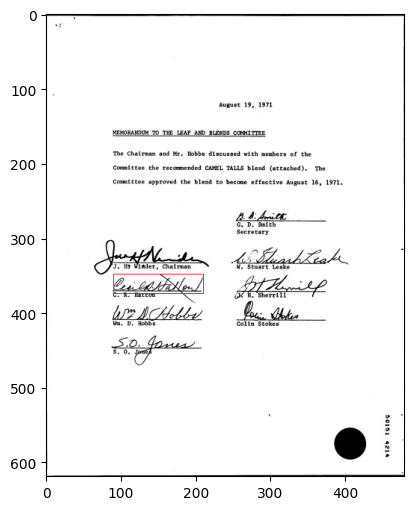

In [ ]:
# 读取一张已经缩放后的图像
img = cv2.imread('/content/drive/MyDrive/tobacco_data/Document_scaled/agw39d00.jpg')

# 在图像上绘制一个矩形框
# 参数设置：矩形左上角坐标(x,y)，矩形右下角坐标(x+w,y+h)，矩形BGR格式颜色，形线条的粗细
img = cv2.rectangle(img, (90, 348), (90+120, 348+26), (255, 0, 0), 1)

# 创建一个6x6英寸的绘图窗口
plt.figure(figsize=(6, 6))
# 用matplotlib显示图像
# matplotlib默认使用RGB，而OpenCV读取的是BGR，所以显示的颜色可能会偏差，这里绘制蓝色会显示为红色
plt.imshow(img)

In [ ]:
# 将包含原始信息和缩放后信息的DataFrame指定列保存为CSV文件
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('/content/drive/MyDrive/tobacco_data/Description_CSV.csv', index=False)
data.head()

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_1.tif,0.tif,3296,2560,NA,NA,DLLogo,None,1074,18,374,219,aah97e00-page02_1.jpg,201,3,70,41,618.000000,480.0
1,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
2,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
3,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
4,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0


In [ ]:
# 读取之前保存的包含缩放后标注信息的CSV文件
df = pd.read_csv('/content/drive/MyDrive/tobacco_data/Description_CSV.csv')

# 对类别字段进行编码，标签→数字
le = LabelEncoder()
df['labels'] = le.fit_transform(df['category']) # 新增一列labels
print(le.classes_) # 输出类别名称，如['DLLogo''DLSignature']

# 计算目标框中心点坐标，向下取整
df['x_center'] = (df['x_scaled'] + df['w_scaled'] / 2).astype(int)
df['y_center'] = (df['y_scaled'] + df['h_scaled'] / 2).astype(int)

# 将中心点坐标和宽高归一化到[0,1]区间
# 横向归一化，除以页面宽度
df['x_center_norm'] = df['x_center'] / df['page_width_scaled']
df['width_norm'] = df['w_scaled'] / df['page_width_scaled']
# 纵向归一化，除以页面高度
df['y_center_norm'] = df['y_center'] / df['page_height_scaled']
df['height_norm'] = df['h_scaled'] / df['page_height_scaled']

df.head()

['DLLogo' 'DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,...,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_1.tif,aah97e00-page02_1.jpg,0.tif,3296,2560,618.000000,480.0,NaN,NaN,DLLogo,...,3,70,41,0,236,23,0.491667,0.145833,0.037217,0.066343
1,aah97e00-page02_2.tif,aah97e00-page02_2.jpg,1.tif,3296,2560,618.000000,480.0,"Boder, J.B.",Yes,DLSignature,...,148,123,67,1,325,181,0.677083,0.256250,0.292880,0.108414
2,aam09c00.tif,aam09c00.jpg,2.tif,2292,1728,636.666667,480.0,"Koplow, M.G.",Yes,DLSignature,...,395,210,50,1,333,420,0.693750,0.437500,0.659686,0.078534
3,aao54e00_2.tif,aao54e00_2.jpg,4.tif,3296,2560,618.000000,480.0,"Landry, J.T.",Yes,DLSignature,...,132,117,38,1,341,151,0.710417,0.243750,0.244337,0.061489
4,abm69c00.tif,abm69c00.jpg,5.tif,2292,1728,636.666667,480.0,"Feldman, J.D.",Yes,DLSignature,...,355,171,30,1,270,370,0.562500,0.356250,0.581152,0.047120


In [ ]:
#df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
#print(df_train.shape, df_valid.shape)

# 将数据集划分为80%训练集、10%验证集和10%测试集
# 先从总数据集中划分80%训练集和20%临时集
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=13, shuffle=True) # 打乱数据，避免样本顺序对划分产生偏差
# 再把临时集等分为验证集和测试集，各占10%
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=13, shuffle=True) # 固定随机种子，保证结果可复现

# 查看划分后各个数据集的规模
print(df_train.shape, df_valid.shape, df_test.shape)

(1073, 26) (134, 26) (135, 26)


In [ ]:
# 创建YOLO格式数据集的主目录
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/')

# 创建存放图像的目录
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/')
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/train/') # 训练集图像
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/valid/') # 验证集图像
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/test/')  # 测试集图像

# 创建存放标签的目录
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/')
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/train/') # 训练集标签
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/valid/') # 验证集标签
os.mkdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/test/')  # 测试集标签

In [ ]:
# 将原始数据集整理为YOLO格式的训练、验证或测试集。
"""
 参数：df:包含图像文件名及对应标注信息
    img_path:原始图像所在路径，是已缩放后的图像
    label_path:原始标注文件所在路径
    train_img_path:整理后的图像存放路径
    train_label_path:整理后的YOLO标注存放路径
"""
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  # 提取所有文件名到列表
  filenames = [] # 初始化文件名列表
  for filename in df.filename:
    filenames.append(filename) # 将DataFrame中的每个文件名加入列表
  # 去重，得到唯一文件名集合，避免同一张图被重复处理
  filenames = set(filenames)

  # 遍历每个唯一文件名，生成对应的YOLO标注
  for filename in filenames:
    yolo_list = [] # 初始化当前图像的YOLO标注列表

    # 遍历该图像对应的每一行标注，可能有多个目标
    for _,row in df[df.filename == filename].iterrows():
      # YOLO格式：类别,中心点x,中心点y,宽度,高度
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])
    # 转换为numpy数组，便于保存
    yolo_list = np.array(yolo_list)

    # 保存img和txt文件到相应的训练和验证文件夹
    # 定义YOLO标注文件名，与图像同名但后缀为.txt
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    # 保存YOLO标签空文件，fmt规定了输出格式：类别是整数，坐标和尺寸是浮点数
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    # 将对应的图像文件复制到以下目标目录
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))

# 应用函数
# 原始图像路径，是已缩放后的图像
src_img_path = "/content/drive/MyDrive/tobacco_data/Document_scaled"
# 原始XML标注路径
src_label_path = "/content/drive/MyDrive/tobacco_data/Description_XML"

# 训练集路径
train_img_path = "/content/drive/MyDrive/tobacco_data/yolo_format/images/train"
train_label_path = "/content/drive/MyDrive/tobacco_data/yolo_format/labels/train"

# 验证集路径
valid_img_path = "/content/drive/MyDrive/tobacco_data/yolo_format/images/valid"
valid_label_path = "/content/drive/MyDrive/tobacco_data/yolo_format/labels/valid"

# 测试集路径
test_img_path = "/content/drive/MyDrive/tobacco_data/yolo_format/images/test"
test_label_path = "/content/drive/MyDrive/tobacco_data/yolo_format/labels/test"


# 分别将训练、验证和测试集整理为YOLO格式
segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)
segregate_data(df_test, src_img_path, src_label_path, test_img_path, test_label_path)

# 打印统计结果，确保图像和标签数量一致
print("No. of Training images", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/train')))
print("No. of valid images", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/valid')))
print("No. of test images", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/images/test')))
print("No. of test labels", len(os.listdir('/content/drive/MyDrive/tobacco_data/yolo_format/labels/test')))

No. of Training images 759
No. of Training labels 759
No. of valid images 133
No. of valid labels 133
No. of test images 127
No. of test labels 127


In [ ]:
# 定义YOLO的数据集配置内容，YAML格式
# 其中说明了训练集、验证集、测试集的路径，以及类别数量和类别名称
yaml_content = """
train: /content/drive/MyDrive/tobacco_data/yolo_format/images/train
val: /content/drive/MyDrive/tobacco_data/yolo_format/images/valid

test: /content/drive/MyDrive/tobacco_data/yolo_format/images/test

nc: 2
names: ['DLLogo', 'DLSignature']
"""

# 定义保存配置文件的路径
yaml_path = "/content/drive/MyDrive/tobacco_data/yolo_yaml.yaml"
# 将YAML配置写入文件
with open(yaml_path, "w") as f:
    f.write(yaml_content)

# 再次读取文件内容并打印，验证保存是否正确
with open(yaml_path, "r") as f:
    print(f.read())


train: /content/drive/MyDrive/tobacco_data/yolo_format/images/train
val: /content/drive/MyDrive/tobacco_data/yolo_format/images/valid

test: /content/drive/MyDrive/tobacco_data/yolo_format/images/test

nc: 2
names: ['DLLogo', 'DLSignature']



In [ ]:
# 定义待删除的.ipynb_checkpoints文件夹路径列表
# 这些文件夹是Jupyter在编辑时自动生成的缓存目录，并不属于实际数据集的一部分
checkpoints_paths = [
    'tobacco_data/yolo_format/images/train/.ipynb_checkpoints',
    'tobacco_data/yolo_format/images/valid/.ipynb_checkpoints',

    'tobacco_data/yolo_format/images/test/.ipynb_checkpoints',

    'tobacco_data/yolo_format/labels/train/.ipynb_checkpoints',
    'tobacco_data/yolo_format/labels/valid/.ipynb_checkpoints',


    'tobacco_data/yolo_format/labels/test/.ipynb_checkpoints'
]

# 遍历路径列表，逐个尝试删除
for path in checkpoints_paths:
    try:
        shutil.rmtree(path) # 递归删除整个文件夹及其内容
    except FileNotFoundError: # 如果文件夹不存在，则忽略错误继续
        pass